# EEG Data Processing

### About the dataset

The EEG data used is a database collected and made available by the Child Mind Institute. 

It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

In [1]:
%matplotlib inline

import os
import csv
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from fooof import FOOOF, FOOOFGroup

In [2]:
# Import custom project related code
import sys
sys.path.append('/'.join(os.getcwd().split('/')[0:-1]))

from core.db import EEGDB
from core.io import save_pickle, load_pickle
from core.utils import comb_corrs, bet_corrs

## Settings

In [3]:
# Set MNE verbosity level
mne.set_log_level(verbose=False)

### Checking 

In [4]:
# Initialize project database object
db = EEGDB()
subjs = db.check_subjs()

In [5]:
# Load data readme file
rmd_file = os.path.join(db.data_path, 'EEG', 'MIPDB_PublicFile.csv')
df = pd.read_csv(rmd_file)

In [6]:
# Check which subjects are downloaded
all_subjs = set(df.ID)

# Subjects with no data (info from README)
no_dat = ['A00052593', 'A00054122', 'A00055801', 'A00056158', 'A00056640', 'A00056990']

# Check if any subjects still need downloading
to_dl = all_subjs - set(subjs) - set(no_dat)

# Print out results
print('Number of subjects downloaded: ', len(set(subjs)))
print('Number of subjects left to download: ', len(to_dl))

Number of subjects downloaded:  120
Number of subjects left to download:  0


### Subjects

In [7]:
# Set subject to run
cur_subj = subjs[20]

# Get subject data files
dat_f, ev_f, _ = db.get_subj_files(cur_subj)

In [8]:
# Get the resting data file - file 001
temp = [ef.split('_')[1] for ef in ev_f]
temp = [fn[-3:] for fn in temp]
f_ind = None
for i, tt in enumerate(temp):
    if tt == '001':
        f_ind = i
if f_ind is None:
    print('No file found')

In [9]:
# Get file file path for data file & associated event file
dat_f_name = db.gen_dat_path(cur_subj, dat_f[f_ind])
eve_f_name = db.gen_dat_path(cur_subj, ev_f[f_ind])

In [10]:
# Data info / parameters
s_freq = 500

# Load data file
dat = np.loadtxt(dat_f_name, delimiter=',')

In [11]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../data/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

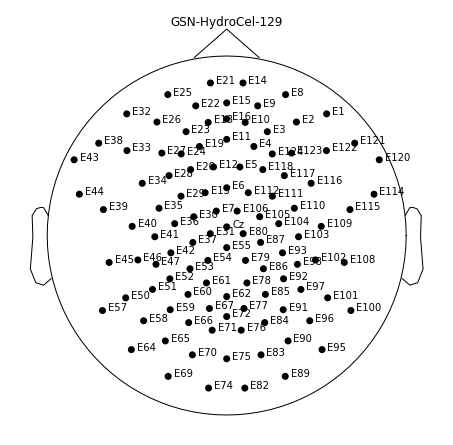

In [12]:
# Check out the montage plot
montage.plot();

In [13]:
# Create the info structure needed by MNE
info = mne.create_info(ch_labels, s_freq, 'eeg', montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(dat, info)

In [14]:
# Create a stim channel
stim_info = mne.create_info(['stim'], s_freq, 'stim')
stim_raw = mne.io.RawArray(np.zeros(shape=[1, len(raw._times)]), stim_info)

# Add stim channel to data object
raw.add_channels([stim_raw], force_update_info=True)

<RawArray  |  None, n_channels x n_times : 112 x 176982 (354.0 sec), ~151.6 MB, data loaded>

In [15]:
# Load events from file

# Initialize headers and variable to store event info
headers = ['type', 'value', 'latency', 'duration', 'urevent']
evs = np.empty(shape=[0, 3])

# Load events from csv file
with open(eve_f_name, 'r') as csv_file:
    
    reader = csv.reader(csv_file)
    for row in reader:

        # Skip the empty rows
        if row == []: continue
        
        # Skip the header row, since there is one for every event...
        if row[0] == 'type': continue
        
        # Collect actual event data rows
        evs = np.vstack((evs, np.array([int(row[2]), 0, int(row[0])])))

# Add events to data object
raw.add_events(evs, stim_channel='stim')

# Check events
dat_evs = mne.find_events(raw)

In [16]:
# Find flat channels and set them as bad
flat_chans = np.mean(raw._data[:111, :], axis=1) == 0
raw.info['bads'] = list(np.array(raw.ch_names[:111])[flat_chans])
print('Bad channels: ', raw.info['bads'])

Bad channels:  ['E1', 'E8', 'E14', 'E21', 'E25', 'E32']


In [17]:
# Interpolate bad channels
raw.interpolate_bads()

<RawArray  |  None, n_channels x n_times : 112 x 176982 (354.0 sec), ~151.6 MB, data loaded>

In [18]:
# Set average reference
raw.set_eeg_reference()
raw.apply_proj()

<RawArray  |  None, n_channels x n_times : 112 x 176982 (354.0 sec), ~151.6 MB, data loaded>

## Resting EEG event descriptions

- 90: Start of the resting EEG paradigm
- 20: Eyes open start (20 seconds)
- 30: Eyes closed start (40 seconds)

^ There should be 5 of each EO and EC

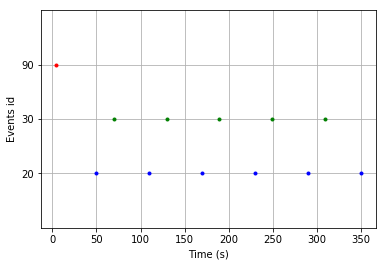

In [19]:
_ = mne.viz.plot_events(dat_evs, raw.info['sfreq'])

In [20]:
# Get good eeg channel indices
eeg_chans = mne.pick_types(raw.info, meg=False, eeg=True)

# Epoch resting eeg data events
eo_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EO': 20}, tmin=2, tmax=18,
                       baseline=None, picks=eeg_chans, preload=True)
ec_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EC': 30}, tmin=2, tmax= 38,
                       baseline=None, picks=eeg_chans, preload=True)

In [21]:
# Plot topo-plots of oscillatory activity
#eo_epochs.plot_psd_topomap();
#ec_epochs.plot_psd_topomap();

In [22]:
# Calculate PSDs - EO Data
eo_psds, eo_freqs = mne.time_frequency.psd_welch(eo_epochs, fmin=2., fmax=40., n_fft=1000,
                                                 n_overlap=250, verbose=False)

# Average PSDs for each channel across each rest block
eo_avg_psds = np.mean(eo_psds, axis=0)

In [23]:
# Calculate PSDs - EC Data
ec_psds, ec_freqs = mne.time_frequency.psd_welch(ec_epochs, fmin=3., fmax=40., n_fft=1000,
                                                 n_overlap=250, verbose=False)

# Average PSDs for each channel across each rest block
ec_avg_psds = np.mean(ec_psds, axis=0)

In [24]:
# Save out PSDs
#np.savez(str(cur_subj) + 'ec_psds.npz', ec_freqs, ec_avg_psds, np.array(ec_epochs.ch_names))
#np.savez(str(cur_subj) + 'eo_psds.npz', eo_freqs, eo_avg_psds, np.array(eo_epochs.ch_names))

### Fit FOOOF (Check)

In [25]:
# Settings
f_range = [3, 35]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 35 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          1.1638, 1.4690                                          
                                                                                                  
                                       4 peaks were found:                                        
          

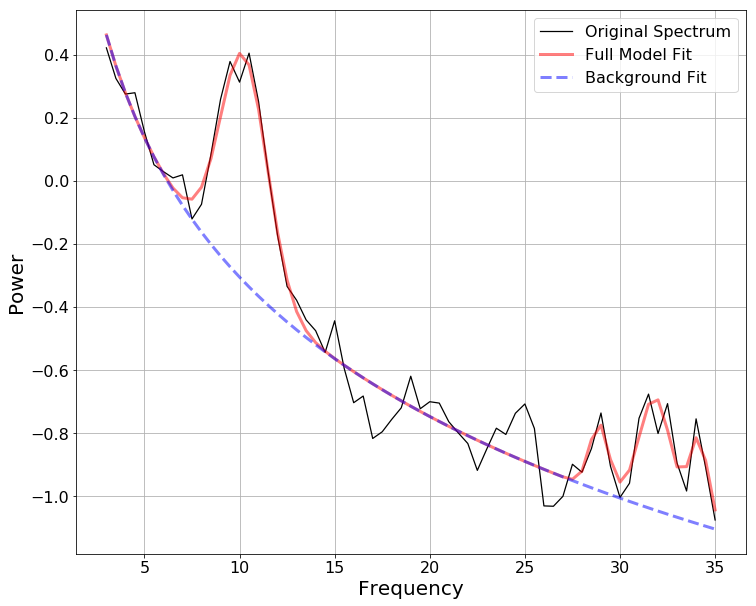

In [26]:
# Fit FOOOF, to example PSD
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_amplitude=0.2)
fm.report(eo_freqs, eo_avg_psds[65, :], f_range)

In [ ]:
# Fit FOOOF to PSDs averaged across rest epochs
fg = FOOOFGroup(peak_width_limits=[1, 8], max_n_peaks=6)

fg.fit(eo_freqs, eo_avg_psds, f_range)
sls_eo_avg = fg.get_all_data('background_params', 'slope')

fg.fit(ec_freqs, ec_avg_psds, f_range)
sls_ec_avg = fg.get_all_data('background_params', 'slope')

Running FOOOFGroup across 111 power spectra.
Running FOOOFGroup across 111 power spectra.


In [ ]:
# Fit FOOOF to PSDs from each epoch

eo_fgs = []
for ep_psds in eo_psds:
    fg.fit(eo_freqs, ep_psds, f_range)
    eo_fgs.append(fg.copy())
    
sls_eo = [fg.get_all_data('background_params', 'slope') for fg in eo_fgs]
    
ec_fgs = []
for ep_psds in ec_psds:
    fg.fit(ec_freqs, ep_psds, f_range)
    ec_fgs.append(fg.copy())
    
sls_ec = [fg.get_all_data('background_params', 'slope') for fg in ec_fgs]

Running FOOOFGroup across 111 power spectra.
Running FOOOFGroup across 111 power spectra.
Running FOOOFGroup across 111 power spectra.
Running FOOOFGroup across 111 power spectra.


In [ ]:
# Get the average slope values 
eo_avgs = [np.mean(sls) for sls in sls_eo]
ec_avgs = [np.mean(sls) for sls in sls_ec]

# Check out the average values
print(np.mean(eo_avgs))
print(np.mean(ec_avgs))

In [ ]:
# Check range of slopes
print(min(sls_eo_avg))
print(max(sls_eo_avg))

print(min(sls_ec_avg))
print(max(sls_ec_avg))

In [ ]:
# Collect data together
subj_dat = {
    'ID' : cur_subj,
    'sls_eo_avg' : sls_eo_avg,
    'sls_ec_avg' : sls_ec_avg,
    'sls_eo' : sls_eo,
    'sls_ec' : sls_ec
}

In [ ]:
# Save out data
f_name = 'test_subj.p'
save_pickle(subj_dat, f_name, db.fooof_path)

In [ ]:
# Check for saved FOOOF files
fres_files = db.check_fooof()
f_ind = fres_files.index(f_name)

In [ ]:
# Load pickle file of FOOOF results
dat = load_pickle(fres_files[f_ind], db.fooof_path)

### Epoch Correlations

In [ ]:
# Check correlations between epochs
corrs_eo = comb_corrs(sls_eo)
print('Corrs within EO: \t', np.mean(corrs_eo))
    
corrs_ec = comb_corrs(sls_ec)
print('Corrs within EC: \t', np.mean(corrs_ec))

corrs_bet = bet_corrs(sls_eo, sls_ec)
print('Corrs betwee EC/EO: \t', np.mean(corrs_bet))

### Topography Plots

In [ ]:
# Plot slope topography from average eyes-open data
mne.viz.plot_topomap(sls_eo_avg, raw.info, cmap=cm.viridis, contours=0);

In [ ]:
# Plot slope topography from average eyes-closed data
mne.viz.plot_topomap(sls_ec_avg, raw.info, cmap=cm.viridis, contours=0);

In [ ]:
# Calculate difference plot between EC and EO
diff_sl = [sec - seo for sec, seo in zip(sls_ec_avg, sls_eo_avg)]

print(min(diff_sl))
print(max(diff_sl))

In [ ]:
# Plot difference map between EC and EO
mne.viz.plot_topomap(diff_sl, raw.info, contours=0);